In [46]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [47]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import tree
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import cross_val_score
import pickle
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:
root = "prototype/"
feature_file = root+"ss_features.csv"
features = pd.read_csv(feature_file)
feature_list = list(features.feature.values)
feature_list

['receiver_avg_waittime_md',
 'receiver_ost_read',
 'receiver_ost_write',
 'receiver_req_active',
 'receiver_seg_out',
 'receiver_segs_in',
 'receiver_system_cpu_percent',
 'receiver_system_memory_percent',
 'sender_avg_waittime_md',
 'sender_cwnd_rate',
 'sender_mds_close_md',
 'sender_ost_read',
 'sender_remote_ost_read_bytes',
 'sender_req_active',
 'sender_req_waittime',
 'sender_req_waittime_md',
 'sender_retrans',
 'sender_segs_in',
 'sender_send_buffer_value',
 'sender_ssthresh_value',
 'sender_system_cpu_percent',
 'sender_system_memory_percent',
 'sender_tcp_snd_buffer_max',
 'sender_write_bytes_io']

In [7]:
filenames = {
    "utah_ssd": "UTAH_25Gbps_ssd_merged.csv",
#     "hpcn_ssd": "hpcn_1Gbps_ssd_merged.csv",
    "wiscon_ssd": "WISCONSIN_10Gbps_ssd_merged.csv",
    "wiscon_hdd": "WISCONSIN_10Gbps_hdd_merged.csv"
}

data = {}

In [29]:
def read_file(transform=False):
    global data, filenames
    
    for key in filenames:      
        df = pd.read_csv(root+filenames[key])
        df = df.sort_values(by=['label_value']).reset_index().drop(columns=["index"])
        df.fillna(df.groupby(['label_value'], as_index=False).mean(), inplace=True)
    
        if transform:
            for index, row in features.iterrows():
                df[row['feature']] = df[row['feature']] / df[row['normalizer']]

        df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        data[key] = df

read_file()

## Cross-Validations

In [85]:
for key in data:
    df = data[key].copy()
    y = df.label_value
    X = df[feature_list]
    clf = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier()) #RandomForestClassifier(n_estimators=100)
    cv_res = np.round(cross_val_score(clf, X, y, cv=10, scoring="f1_weighted"),4)
    print(f'{key} ==>{cv_res}')
    print(f'{key} ==> mean: {np.round(np.mean(cv_res)*100, 2)}, std: {np.round(np.std(cv_res)*100, 2)}')

utah_ssd ==>[0.9721 0.9754 0.9943 0.9861 0.9771 0.9896 0.986  0.9762 0.9861 0.9853]
utah_ssd ==> mean: 98.28, std: 0.68
wiscon_ssd ==>[0.9649 0.9835 0.9621 0.9802 0.9838 0.9859 0.9727 0.9657 0.9881 0.9804]
wiscon_ssd ==> mean: 97.67, std: 0.91
wiscon_hdd ==>[0.9463 0.945  0.9892 0.977  0.9704 0.9662 0.9502 0.962  0.9733 0.9794]
wiscon_hdd ==> mean: 96.59, std: 1.42


## Evaluation

In [76]:
for key in data:
    df = data[key].copy()
    df = df.sample(frac=0.5)
    y = df.label_value
    X = df[feature_list] #.drop(columns="label_value")
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
#     print(X_train.shape)
    
    clf = tree.DecisionTreeClassifier()#RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    # pickle.dump(clf, open(f"{root}{key}.model", "wb"))
    # clf = pickle.load(open(f"{root}{key}.model", "rb"))
    y_pred = clf.predict(X_test)
    np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    print(f"{key} ==> {np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")

utah_ssd ==> 93.45
wiscon_ssd ==> 95.49
wiscon_hdd ==> 92.34


## Features Importance List

In [82]:
features_set = set()
for key in data:
    df = data[key].copy()
    y = df.label_value
    X = df.drop(columns="label_value")
    X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X, y)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    score = np.round(clf.feature_importances_, 2)
    
    for i in range(len(score)):
        if score[i] >= 0.02:
            features_set.add(X.columns[i])

for val in sorted(features_set):
    print(f"{val},")

receiver_avg_waittime_md,
receiver_ost_read,
receiver_ost_write,
receiver_req_active,
receiver_seg_out,
receiver_segs_in,
receiver_system_cpu_percent,
receiver_system_memory_percent,
sender_avg_waittime_md,
sender_cwnd_rate,
sender_ost_read,
sender_read_bytes,
sender_remote_ost_read_bytes,
sender_req_active,
sender_req_waittime,
sender_req_waittime_md,
sender_retrans,
sender_segs_in,
sender_send_buffer_value,
sender_ssthresh_value,
sender_system_cpu_percent,
sender_system_memory_percent,
sender_tcp_snd_buffer_max,
sender_write_bytes_io,


## Transfer Learning

In [69]:
for key1 in data:
    df = data[key1].copy()
    y = df.label_value
    X = df[feature_list] #.drop(columns="label_value")
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    for key2 in data:
        if key1 == key2:
            continue
            
        df_test = data[key2].copy()
        y_test = df_test.label_value
        X_test = df_test[feature_list]
        
        y_pred = clf.predict(X_test)
        np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")

utah_ssd ==> wiscon_ssd - 31.56
utah_ssd ==> wiscon_hdd - 32.58
wiscon_ssd ==> utah_ssd - 58.79
wiscon_ssd ==> wiscon_hdd - 78.93
wiscon_hdd ==> utah_ssd - 61.63
wiscon_hdd ==> wiscon_ssd - 82.52


In [51]:
np.round(df.groupby("label_value").sender_remote_ost_read_bytes.agg(["mean", "std"]),2)

,mean,std
label_value,,
0,1.157957e+08,10140063.12
1,5.461730e+08,12309885.69
17,1.117545e+08,11425497.81
33,1.157628e+08,14963686.55
34,1.111079e+08,12641538.56
35,1.151220e+08,11359041.02
36,9.810677e+07,20922373.95
40,9.585837e+07,29320049.29
44,1.106628e+08,10064329.54


In [106]:
print(f"testbed,samples,score")
for key in data:
    df = data[key].copy()
    for n in range(5,41,5):
        train = df.groupby("label_value").sample(n)
        test = df.drop(train.index)
        y_train = train.label_value
        X_train = train[feature_list]
        y_test = test.label_value
        X_test = test[feature_list]

#         clf = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier())
        clf = tree.DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        # pickle.dump(clf, open(f"{root}{key}.model", "wb"))
        # clf = pickle.load(open(f"{root}{key}.model", "rb"))
        y_pred = clf.predict(X_test)
        np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        print(f"{key},{n},{np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")

testbed,samples,score
utah_ssd,5,84.46
utah_ssd,10,91.0
utah_ssd,15,91.93
utah_ssd,20,95.98
utah_ssd,25,94.32
utah_ssd,30,95.61
utah_ssd,35,95.08
utah_ssd,40,96.69
wiscon_ssd,5,82.19
wiscon_ssd,10,89.13
wiscon_ssd,15,93.13
wiscon_ssd,20,93.62
wiscon_ssd,25,93.51
wiscon_ssd,30,94.28
wiscon_ssd,35,95.53
wiscon_ssd,40,95.97
wiscon_hdd,5,79.47
wiscon_hdd,10,89.87
wiscon_hdd,15,90.35
wiscon_hdd,20,89.43
wiscon_hdd,25,93.33
wiscon_hdd,30,92.16
wiscon_hdd,35,93.92
wiscon_hdd,40,93.26


In [77]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)
    Evaluate a score by cross-validation.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv

In [9]:
df = data["utah_ssd"].copy()

In [13]:
df.groupby("label_value").sender_avg_rtt_value.count()

label_value
0      109
1      661
17    1768
33     410
34     109
35      51
36     438
40     440
44     438
48     879
59     328
62     439
66     888
74     881
82     414
86     111
87      69
88     331
Name: sender_avg_rtt_value, dtype: int64

[Text(0.8461538461538461, 0.9722222222222222, 'X[21] <= 18.4\ngini = 0.944\nsamples = 720\nvalue = [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40\n40, 40, 40, 40, 40, 40]'),
 Text(0.7948717948717948, 0.9166666666666666, 'X[8] <= 409.5\ngini = 0.941\nsamples = 680\nvalue = [40, 40, 40, 40, 40, 0, 40, 40, 40, 40, 40, 40\n40, 40, 40, 40, 40, 40]'),
 Text(0.6923076923076923, 0.8611111111111112, 'X[4] <= 421.0\ngini = 0.933\nsamples = 600\nvalue = [0, 0, 40, 40, 40, 0, 40, 40, 40, 40, 40, 40\n40, 40, 40, 40, 40, 40]'),
 Text(0.6410256410256411, 0.8055555555555556, 'gini = 0.0\nsamples = 40\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 40, 0, 0]'),
 Text(0.7435897435897436, 0.8055555555555556, 'X[15] <= 96535.5\ngini = 0.929\nsamples = 560\nvalue = [0, 0, 40, 40, 40, 0, 40, 40, 40, 40, 40, 40\n40, 40, 40, 0, 40, 40]'),
 Text(0.6410256410256411, 0.75, 'X[12] <= 106430464.0\ngini = 0.917\nsamples = 480\nvalue = [0, 0, 0, 40, 40, 0, 40, 40, 40, 40, 40, 40, 0\n40, 40, 0, 40, 40]'),
 Te

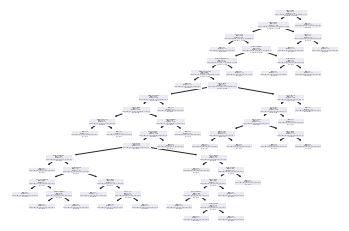

In [90]:
tree.plot_tree(clf)

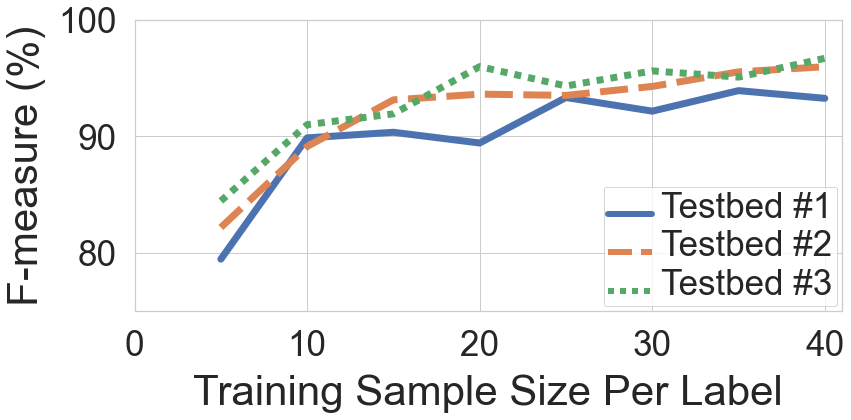

In [111]:
sns.set_style("whitegrid")
df = pd.read_csv("prototype/sample_vs_score.csv")
df = df.replace({
    "wiscon_hdd": "Testbed #1", 
    "wiscon_ssd": "Testbed #2",
    "utah_ssd": "Testbed #3"
})

df = df.sort_values(by=['testbed'])
ax = sns.lineplot(x="samples", y="score", hue="testbed", data=df, style="testbed", ms=18, lw=7)

ax.set_ylabel("F-measure (%)", fontsize=42, labelpad=12);
plt.xlabel("Training Sample Size Per Label", fontsize=42, labelpad=12)
plt.rcParams["figure.figsize"] = (12, 6)

plt.xlim(0, 41)
plt.ylim(75,100)
# plt.legend(loc="lower right", handlelength=4, ncol=2)
plt.xticks(range(0,41,10))
plt.legend(loc="lower right", handlelength=4, ncol=1)
plt.setp(ax.get_legend().get_texts(), fontsize='35')
plt.setp(ax.get_legend().get_lines(), lw=6)
# ax.legend(loc="lower right", handlelength=4, ncol=2)
# plt.legend(loc="upper center",fontsize=25)
# plt.xticks(rotation = 30)
ax.tick_params(axis='both', which='major', pad=12)
ax.tick_params(axis='y', which='major', labelsize=35)
ax.tick_params(axis='x', which='major', labelsize=35)
plt.tight_layout()
plt.savefig("size_vs_score.pdf")
plt.show()